# Parcial 2:



### Instalar root en la máquina virtual:


In [1]:
!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libxext-dev is already the newest version (2:1.3.3-1).
libxft-dev is already the newest version (2.3.2-1).
libxpm-dev is already the newest version (1:3.5.12-1).
subversion is already the newest version (1.9.7-4ubuntu1).
binutils is already the newest version (2.30-21ubuntu1~18.04.2).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
dpkg-dev is already the newest version (1.19.0.5ubuntu2.3).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
gfortran is already the newest version (4:7.4.0-1ubuntu2.3).
git is already the newest version (1:2.17.1-1ubuntu0.4).
libx11-dev is already the newest version (2:1.6.4-3ubuntu0.2).
tar is already the newest version (1.29b-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/Shared drives/PyROOT_in_Google/"

BasicAnalysis.ipynb	  HistogrammingInROOT.ipynb
BasicPyROOTExample.ipynb  monje-a-lo-bonzo-blanco-y-negro.png
Chi2Fitting.ipynb	  piano-C5.wav
Data5.root		  Random2DHistos
DatosParcial2		  root_build_google_yikes.tar
DatosResonancia.root	  Temporal
FFT_imagen.ipynb	  TrimmedTree.root
FFT.ipynb		  TTreeExcercise.ipynb
FLUTEMI.WAV


In [0]:
!tar -xf /content/drive/Shared\ drives/PyROOT_in_Google/root_build_google_yikes.tar

In [5]:
!ls -ltrh

total 12K
drwxr-xr-x 44 root root 4.0K Sep 20  2018 root_build
drwxr-xr-x  1 root root 4.0K Nov  6 16:17 sample_data
drwx------  4 root root 4.0K Nov 17 12:37 drive


In [0]:
import sys
sys.path.append("/content/root_build/")
sys.path.append("/content/root_build/bin/")
sys.path.append("/content/root_build/include/")
sys.path.append("/content/root_build/lib/")

#1: Leer los datos y graficar el histograma

In [7]:
import ROOT
import numpy as np
from numpy import pi
from scipy import integrate
import random
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

Welcome to JupyROOT 6.14/04


In [8]:
DataChain=ROOT.TChain("SystemTree")
DataChain.Add("/content/drive/Shared drives/PyROOT_in_Google/DatosParcial2/N1020492516.root")

1

In [9]:
NumberEvents=DataChain.GetEntries()
print("Son ",NumberEvents, " eventos")

Son  80000  eventos


In [0]:
DG = ROOT.TH1F( 'DG', 'Datos parcial 2', 200, 100, 1200 )
datos = []
for entry in DataChain:
  DG.Fill(entry.x)
  datos.append(entry.x)

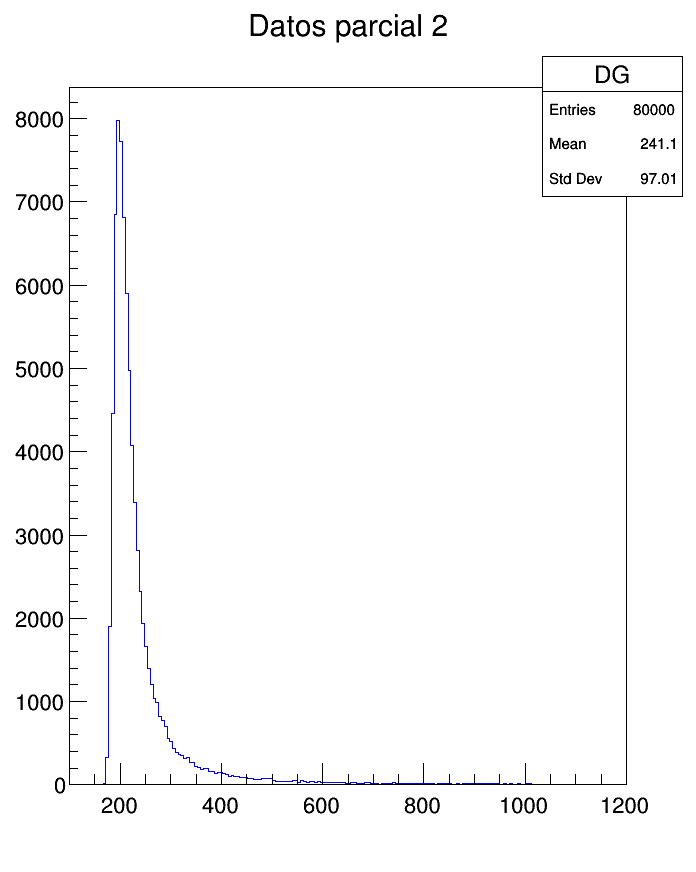

In [11]:
c1 = ROOT.TCanvas( 'c1', 'Datos', 200, 10, 700, 900 )
c1.SetFillColor( 0 )
DG.Draw()
DG.SetLineColor(4)
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

Minimo y máximo:  167.1897430419922 6223181.5


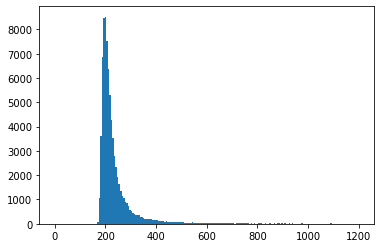

In [12]:
plt.hist(datos, bins=200, range=(0,1200))
plt.plot()
print('Minimo y máximo: ',min(datos),max(datos))

###Definiciones de Landau

In [0]:
def P1(t,x,mu,c):
    #mu = 0
    #c = 0.1
    p= (1/(pi*c))*np.exp(-t)*np.cos(t*(x-mu)/c + 2*t*np.log(t/c)/pi)
    return p

def P1fint(x,mu,c):
    a = integrate.quad(P1, 0, np.inf,args=(x,mu,c))#integra en t, en args entra x, mu, c
    return a#devuelve solo el valor de la integral, el error pa la mierda

def Rlandau( x, mu , c ):
        I = ROOT.TMath.Landau(x, mu , c, True)
        if I ==0:
            return 1e-7
        else:
            return I

mue = 241.1 #Mu esperado dado por los datos de root
ce = 97.01  #C esperado dado por los datos de root

##Metropolis

80000


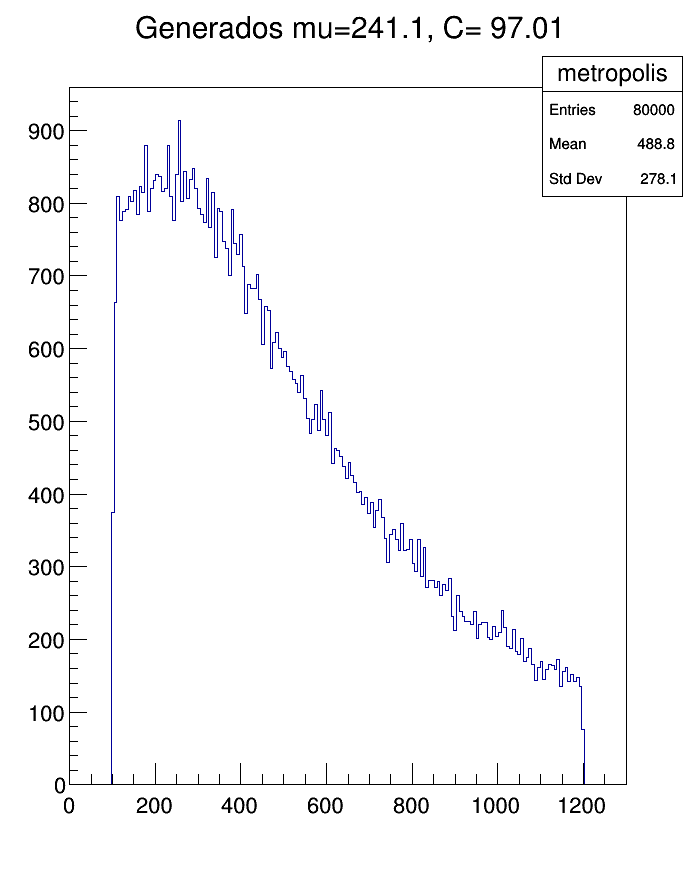

In [14]:
def metropolis(P,mu,c,n):#Función, mu, c, numero de eventos
  x=[]
  xa=[]
  x.append(1200*random.random()+100)
  i=0
  #for i in range(0,80000):
  while i<(n-1):
    xp = 1100*random.random() + 100 
    ds = -np.log(P(xp,mu,c)/P(x[-1],mu,c))
    if ds<0:
        x.append(xp)
        i+=1
    elif ds > 0:
        xnada = random.random()
        Pg = P(xp,mu,c)/P(x[-1],mu,c)
        if xnada < Pg:
                 x.append(xp)
                 i+=1
  return x

N = DG.GetEntries()
generados1 = metropolis(Rlandau, mue , ce, N)
print(len(generados1))

hist_metrop = ROOT.TH1F('metropolis', 'Generados mu=241.1, C= 97.01',200,0,1300)
for i in range(0,len(generados1)):
  hist_metrop.Fill(generados1[i])
hist_metrop.Draw()
ROOT.gROOT.GetListOfCanvases().Draw()

## Buscar mu y c optimos

In [0]:
def chi(x,y,n):#x: Datos, y:Metropolis, n:bins
  suma = 0
  for i in range(0,len(x)):
    suma = suma + (((x[i] - y[i])**2)/x[i])
  return (1/n)*suma

chilist = []
muL = []
muR = np.arange(120,250,5)
cR = np.arange(10, 40,10)
for i in muR:
  generados = metropolis(Rlandau,i,50,N)
  chii = chi(datos,generados,10)
  muL.append(i)
  chilist.append(chii)
Muop = muL[chilist.index(min(chilist))]#mu optimo

In [16]:
print('Mu que minimiza chi2', muL[chilist.index(min(chilist))])

Mu que minimiza chi2 190


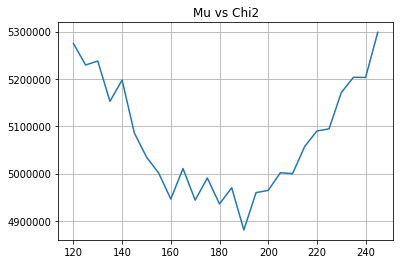

In [17]:
plt.plot(muR,chilist)
plt.title('Mu vs Chi2')
plt.grid()
plt.show()

In [0]:
chilist = []
cL = []
cR = np.arange(1, 4,1)
for i in cR:
  generados = metropolis(Rlandau,Muop,i,N)
  chii = chi(datos,generados,10)
  cL.append(i)
  chilist.append(chii)
cop= cL[chilist.index(min(chilist))]

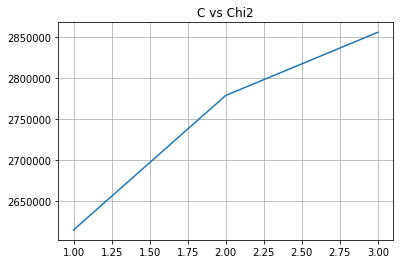

In [20]:
plt.plot(cL,chilist)
plt.title('C vs Chi2')
plt.grid()
plt.show()


#Lo siguiende es para hacer gráfico 3d, se demora

In [0]:
cR = np.linspace(1,15,5)
muR = np.linspace(150,250,5)

muA = []
cA = []
chiA = []

for i in muR:
  cL = []
  muL = []
  chiL = []
  for j in cR:
    generados = metropolis(Rlandau,i,j,N)
    chii = chi(datos,generados,10)
    chiL.append(chii)
    muL.append(i)
    cL.append(j)

  cA.append(cL)
  muA.append(muL)
  chiA.append(chiL)



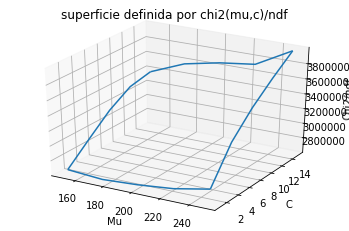

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cA = np.array(cA)
muA = np.array(muA)
chiA = np.array(chiA)
ax.plot_wireframe(muA, cA,chiA, rstride=20, cstride=20)
ax.set_title('superficie definida por chi2(mu,c)/ndf')
ax.set_xlabel('Mu')
ax.set_ylabel('C')
ax.set_zlabel('Chi2/ndf')
plt.show()

#Grafica de datos generados y comparación con los originales

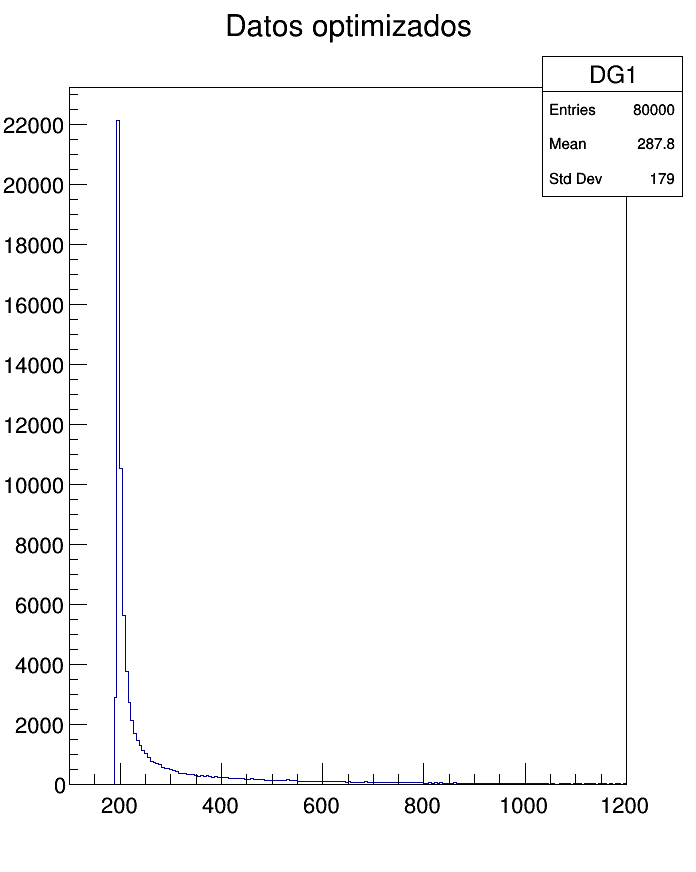

In [23]:
optimize = metropolis(Rlandau,195,1,N)
DG1 = ROOT.TH1F( 'DG1', 'Datos optimizados', 200, 100, 1200 )
for i in range(0,len(optimize)):
  DG1.Fill(optimize[i])

DG1.Draw()
ROOT.gROOT.GetListOfCanvases().Draw()

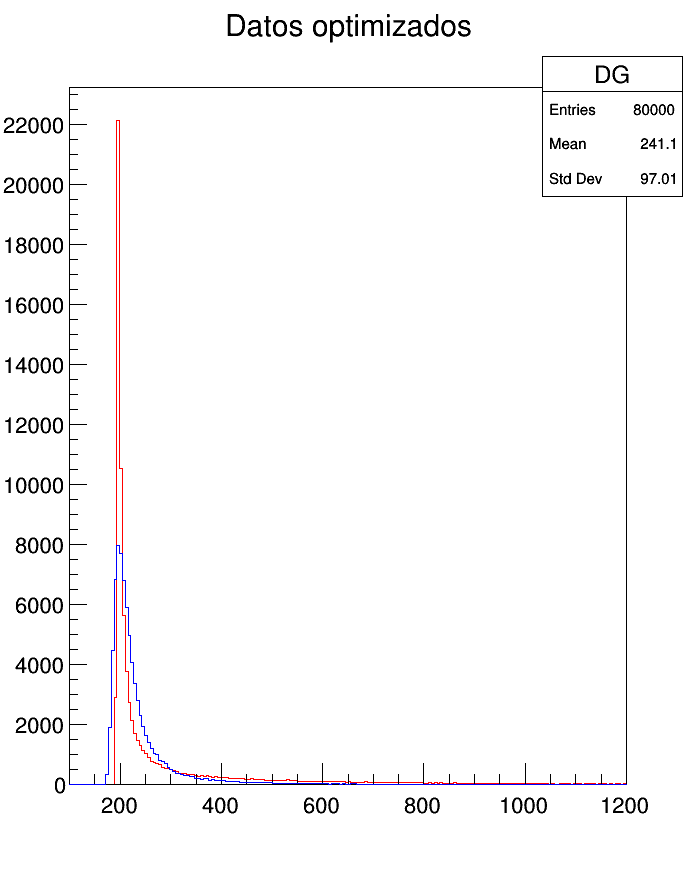

In [24]:
DG1.Draw() #Roja
DG1.SetLineColor(2) 

DG.Draw('same')
DG.SetLineColor(4)

c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()